In [ ]:
!pip install torchsummary

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from torchsummary import summary
from torch.autograd import Variable
from torchvision import transforms, datasets

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = IMAGE_HEIGHT // 3  # 3:1 ratio
NUM_CLASSES = 54  # 10+44
EPOCHS = 100

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
    ]
)

In [4]:
from google.colab import drive
drive.mount('./drive/')
!unzip './drive/MyDrive/characters.zip' -d './dataset'

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/characters/007/2024_03_20_V00006_cropped_2.png  
  inflating: ./dataset/characters/007/2024_03_20_V00046_cropped_3.png  
  inflating: ./dataset/characters/007/2024_03_20_V00090_cropped_1.png  
  inflating: ./dataset/characters/007/2024_03_20_V00119_cropped_3.png  
  inflating: ./dataset/characters/007/2024_03_26_V02461_cropped_2.png  
  inflating: ./dataset/characters/007/2024_03_26_V02552_cropped_3.png  
  inflating: ./dataset/characters/007/2024_03_27_V02730_cropped_3.png  
  inflating: ./dataset/characters/007/2024_03_27_V02742_cropped_2.png  
  inflating: ./dataset/characters/007/2024_03_27_V02748_cropped_3.png  
  inflating: ./dataset/characters/007/2024_03_27_V02760_cropped_3.png  
  inflating: ./dataset/characters/007/2024_03_27_V02853_cropped_2.png  
  inflating: ./dataset/characters/007/2024_03_27_V02946_cropped_1.png  
  inflating: ./dataset/characters/007/2024_03_27_V02952_cropped_3.png  
  inflating: 

In [5]:
# Add empty folder check to ImageFolder
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        try:
            super().__init__(root=root, transform=transform)
        except FileNotFoundError as e:
            print(f"Warning: {e}")
            print("Continuing with available classes...")
            super().__init__(root=root, transform=transform, is_valid_file=lambda x: True, allow_empty=True)

In [6]:
training_set_path = "./dataset/characters"

train_split = 0.8
full_training_set = CustomImageFolder(root=training_set_path, transform=transform)
train_size = int(train_split * len(full_training_set))
test_size = len(full_training_set) - train_size
training_set, validation_set = torch.utils.data.random_split(
    full_training_set, [train_size, test_size]
)

training_loader = torch.utils.data.DataLoader(
    training_set, batch_size=BATCH_SIZE, shuffle=True
)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=BATCH_SIZE, shuffle=False
)

print("Training set has {} instances".format(len(training_set)))
print("Validation set has {} instances".format(len(validation_set)))

Continuing with available classes...
Training set has 5226 instances
Validation set has 1307 instances


In [7]:
class_labels = full_training_set.classes
class_labels_index = full_training_set.class_to_idx
print("Number of Classes:", len(class_labels))
print("Class Labels:", class_labels)
print("Class Labels Index:", class_labels_index)

Number of Classes: 54
Class Labels: ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010ก', '011ข', '012ฃ', '013ค', '014ฅ', '015ฆ', '016ง', '017จ', '018ฉ', '019ช', '020ซ', '021ฌ', '022ญ', '023ฎ', '024ฏ', '025ฐ', '026ฑ', '027ฒ', '028ณ', '029ด', '030ต', '031ถ', '032ท', '033ธ', '034น', '035บ', '036ป', '037ผ', '038ฝ', '039พ', '040ฟ', '041ภ', '042ม', '043ย', '044ร', '045ล', '046ว', '047ศ', '048ษ', '049ส', '050ห', '051ฬ', '052อ', '053ฮ']
Class Labels Index: {'000': 0, '001': 1, '002': 2, '003': 3, '004': 4, '005': 5, '006': 6, '007': 7, '008': 8, '009': 9, '010ก': 10, '011ข': 11, '012ฃ': 12, '013ค': 13, '014ฅ': 14, '015ฆ': 15, '016ง': 16, '017จ': 17, '018ฉ': 18, '019ช': 19, '020ซ': 20, '021ฌ': 21, '022ญ': 22, '023ฎ': 23, '024ฏ': 24, '025ฐ': 25, '026ฑ': 26, '027ฒ': 27, '028ณ': 28, '029ด': 29, '030ต': 30, '031ถ': 31, '032ท': 32, '033ธ': 33, '034น': 34, '035บ': 35, '036ป': 36, '037ผ': 37, '038ฝ': 38, '039พ': 39, '040ฟ': 40, '041ภ': 41, '042ม': 42, '043ย': 43, '044ร': 44, 

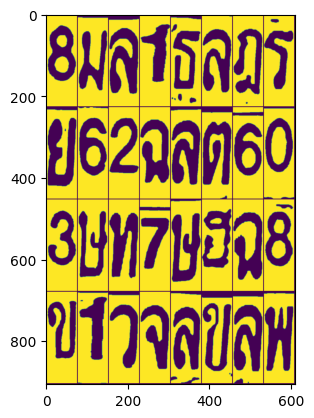

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=True):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [9]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [10]:
def count_model_param_flops(model=None, input_res_h = 224, input_res_w = 224, multiply_adds=True):

    prods = {}

    def save_hook(name):
        def hook_per(self, input, output):
            prods[name] = np.prod(input[0].shape)

        return hook_per

    list_1 = []

    def simple_hook(self, input, output):
        list_1.append(np.prod(input[0].shape))

    list_2 = {}

    def simple_hook2(self, input, output):
        list_2["names"] = np.prod(input[0].shape)

    list_conv = []

    def conv_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = (
            self.kernel_size[0] * self.kernel_size[1] * (self.in_channels / self.groups)
        )
        bias_ops = 1 if self.bias is not None else 0

        params = output_channels * (kernel_ops + bias_ops)
        # flops = (kernel_ops * (2 if multiply_adds else 1) + bias_ops) * output_channels * output_height * output_width * batch_size

        num_weight_params = (self.weight.data != 0).float().sum()
        flops = (
            (
                num_weight_params * (2 if multiply_adds else 1)
                + bias_ops * output_channels
            )
            * output_height
            * output_width
            * batch_size
        )

        list_conv.append(flops)

    list_linear = []

    def linear_hook(self, input, output):
        batch_size = input[0].size(0) if input[0].dim() == 2 else 1

        weight_ops = self.weight.nelement() * (2 if multiply_adds else 1)
        bias_ops = self.bias.nelement()

        flops = batch_size * (weight_ops + bias_ops)
        list_linear.append(flops)

    list_bn = []

    def bn_hook(self, input, output):
        list_bn.append(input[0].nelement() * 2)

    list_relu = []

    def relu_hook(self, input, output):
        list_relu.append(input[0].nelement())

    list_pooling = []

    def pooling_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size * self.kernel_size
        bias_ops = 0
        params = 0
        flops = (
            (kernel_ops + bias_ops)
            * output_channels
            * output_height
            * output_width
            * batch_size
        )

        list_pooling.append(flops)

    list_upsample = []

    # For bilinear upsample
    def upsample_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        flops = output_height * output_width * output_channels * batch_size * 12
        list_upsample.append(flops)

    def foo(net):
        childrens = list(net.children())
        if not childrens:
            if isinstance(net, torch.nn.Conv2d):
                net.register_forward_hook(conv_hook)
            if isinstance(net, torch.nn.Linear):
                net.register_forward_hook(linear_hook)
            if isinstance(net, torch.nn.BatchNorm2d):
                net.register_forward_hook(bn_hook)
            if isinstance(net, torch.nn.ReLU):
                net.register_forward_hook(relu_hook)
            if isinstance(net, torch.nn.MaxPool2d) or isinstance(
                net, torch.nn.AvgPool2d
            ):
                net.register_forward_hook(pooling_hook)
            if isinstance(net, torch.nn.Upsample):
                net.register_forward_hook(upsample_hook)
            return
        for c in childrens:
            foo(c)

    if model == None:
        model = torchvision.models.alexnet()
    foo(model)
    input = Variable(
        torch.rand(3, input_res_h, input_res_w).unsqueeze(0), requires_grad=True
    )
    out = model(input)

    total_flops = (
        sum(list_conv)
        + sum(list_linear)
        + sum(list_bn)
        + sum(list_relu)
        + sum(list_pooling)
        + sum(list_upsample)
    )

    print(
        "Number of FLOPs: %.6f GFLOPs (%.2f MFLOPs)"
        % (total_flops / 1e9, total_flops / 1e6)
    )

    return total_flops

In [11]:
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )

        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        )

        self.fc1 = nn.Linear(128 * (IMAGE_HEIGHT // 8) * (IMAGE_WIDTH // 8), 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


model = Model().to(device)

summary(model, (3, IMAGE_HEIGHT, IMAGE_WIDTH))
count_model_param_flops(
    model=model.to("cpu").eval(), input_res_h = IMAGE_HEIGHT, input_res_w = IMAGE_WIDTH, multiply_adds=True
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 224, 74]             896
         MaxPool2d-2          [-1, 32, 112, 37]               0
            Conv2d-3          [-1, 64, 112, 37]          18,496
         MaxPool2d-4           [-1, 64, 56, 18]               0
            Conv2d-5          [-1, 128, 56, 18]          73,856
         MaxPool2d-6           [-1, 128, 28, 9]               0
            Linear-7                  [-1, 256]       8,257,792
            Linear-8                   [-1, 54]          13,878
Total params: 8,364,918
Trainable params: 8,364,918
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 8.81
Params size (MB): 31.91
Estimated Total Size (MB): 40.91
----------------------------------------------------------------
Number of FLOPs: 0.348429 GFLOPs (34

tensor(3.4843e+08)

In [12]:
model = Model().to(device)
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


epoch_number = 0
path_save_cp = "./"
best_vloss = 1_000_000.0
training_logs = {
    "train_loss": [],
    "train_acc": [],
    "validate_loss": [],
    "validate_acc": [],
}

In [13]:
patience = 5
min_delta = 0.001
best_vloss = float("inf")
epochs_no_improve = 0
t_0_accelerated = time.time()

for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    model.train(True)

    for i, data in enumerate(training_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    model.eval()
    valid_loss, valid_correct = 0, 0

    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()

        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(
            valid_correct / len(validation_loader.dataset)
        )

    if epoch % 1 == 0:
        print(
            f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",
            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
        )
        print("-" * 80)

    if valid_loss < best_vloss - min_delta:
        best_vloss = valid_loss
        epochs_no_improve = 0
        if not os.path.exists(path_save_cp):
            os.mkdir(path_save_cp)
        model_dict = {
            'state_dict': model.state_dict(),
            'class_mapping': full_training_set.class_to_idx
        }
        torch.save(model_dict, path_save_cp + "Characters_CNN.pth")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience and epoch > 50:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

t_end_accelerated = time.time() - t_0_accelerated
print(
    f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec"
)

Epochs 1   train loss 0.75888 train acc 0.83104 validate loss 0.13210 validate acc 0.96557
--------------------------------------------------------------------------------
Epochs 2   train loss 0.07978 train acc 0.98240 validate loss 0.09835 validate acc 0.98164
--------------------------------------------------------------------------------
Epochs 3   train loss 0.02845 train acc 0.99330 validate loss 0.08464 validate acc 0.98164
--------------------------------------------------------------------------------
Epochs 4   train loss 0.02643 train acc 0.99254 validate loss 0.06975 validate acc 0.98393
--------------------------------------------------------------------------------
Epochs 5   train loss 0.01119 train acc 0.99809 validate loss 0.06114 validate acc 0.98776
--------------------------------------------------------------------------------
Epochs 6   train loss 0.00622 train acc 0.99847 validate loss 0.06874 validate acc 0.98623
-------------------------------------------------

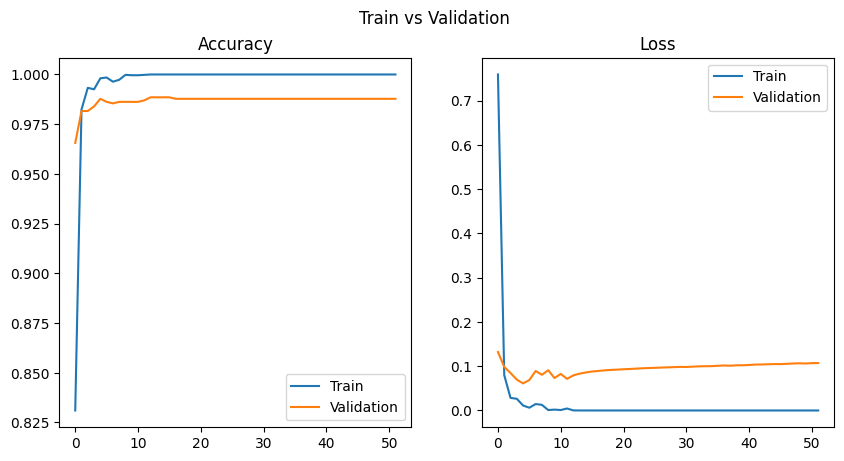

In [14]:
plot_graph(training_logs)

In [15]:
PATH = "./Characters_CNN.pth"
checkpoint = torch.load(PATH, map_location=torch.device("cpu"))
loaded_model = model
loaded_model.load_state_dict(checkpoint['state_dict'])
acc_test = 0
test_loss = 0
loaded_model.to(device).eval()
stored_lbs = torch.empty(0, dtype=torch.float32).to(device)
stored_preds = torch.empty(0, dtype=torch.float32).to(device)
t_0_accelerated = time.time()

with torch.no_grad():
    for i, tdata in enumerate(validation_loader):
        tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
        toutputs = loaded_model(tinputs)
        loss = loss_fn(toutputs, tlabels)
        test_loss += loss
        _, preds_t = torch.max(toutputs, 1)
        acc_test += (preds_t == tlabels).float().mean().item()
        stored_lbs = torch.cat((stored_lbs, tlabels), 0)
        stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
t_end_accelerated = time.time() - t_0_accelerated
print(
    "[(test loss: {}] [accuracy_test: {} %]".format(
        avg_tloss, accuracy_t * 100
    )
)
print(
    f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec"
)

<ipython-input-15-d6a91fe0a7f7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH, map_location=torch.device("cpu"))


[(test loss: 0.061141837388277054] [accuracy_test: 98.78 %]
Time consumption for accelerated CUDA training (device:cuda): 12.761348485946655 sec


In [16]:
from sklearn.metrics import (
    precision_recall_fscore_support,
    normalized_mutual_info_score,
    adjusted_rand_score,
)

lb = stored_lbs.cpu()
prd = stored_preds.cpu()

# ---F1-score/Precision/Recall scores
print(
    "Precision/Recall/F-beta score:",
    precision_recall_fscore_support(
        lb, prd, average="weighted", zero_division=0, beta=1.0
    ),
)

# ---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(
    labels_true=lb,
    labels_pred=prd,
    average_method="arithmetic",
)

# ---Rand Index (RI) score
ri_score = adjusted_rand_score(
    labels_true=lb,
    labels_pred=prd,
)

print(f"NMI score: {nmi_score}, RI score: {ri_score}")

Precision/Recall/F-beta score: (0.9881149800000222, 0.9877582249426167, 0.9876255295069153, None)
NMI score: 0.9878611865572929, RI score: 0.9836939535861534


#### onnx

In [17]:
!pip install onnx
!pip install onnxscript
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.6/691.6 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.6 MB/s eta 0:00:00


In [18]:
import onnx
import onnxruntime as ort

In [19]:
def inspect_onnx_model(model_path):
    # Load ONNX model
    model = onnx.load(model_path)

    # Print model inputs
    print("\nModel Inputs:")
    for input in model.graph.input:
        print(f"Name: {input.name}")
        print(f"Shape: {[d.dim_value for d in input.type.tensor_type.shape.dim]}")

    # Print model outputs
    print("\nModel Outputs:")
    for output in model.graph.output:
        print(f"Name: {output.name}")
        print(f"Shape: {[d.dim_value for d in output.type.tensor_type.shape.dim]}")

    # Create an inference session to get more details
    session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])

    print("\nDetailed Input Info:")
    for i in session.get_inputs():
        print(f"Name: {i.name}")
        print(f"Shape: {i.shape}")
        print(f"Type: {i.type}")

    print("\nDetailed Output Info:")
    for o in session.get_outputs():
        print(f"Name: {o.name}")
        print(f"Shape: {o.shape}")
        print(f"Type: {o.type}")

In [20]:
from PIL import Image

def test_single_image(image_path, model_path, class_mapping):
    # Initialize ONNX Runtime session
    session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image)
    input_data = image_tensor.unsqueeze(0).numpy()

    # Run inference
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: input_data.astype(np.float32)})
    probabilities = outputs[0][0]

    # Get top predictions
    top_indices = np.argsort(probabilities)[-5:][::-1]  # Get top 5

    print("\nPredictions:")
    for idx in top_indices:
        print(f"Index {idx}: Class {[k for k,v in class_mapping.items() if v == idx][0]}, "
              f"Probability: {probabilities[idx]:.4f}")

    return probabilities

In [21]:
checkpoint = torch.load('Characters_CNN.pth')
torch_model = Model()
torch_model.load_state_dict(checkpoint['state_dict'])
class_mapping = checkpoint['class_mapping']
torch_model.eval()
torch_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)

input_names = ["input"]
output_names = ["output"]
dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}

torch.onnx.export(torch_model,
                  torch_input,
                  "Characters_CNN.onnx",
                  export_params=True,
                  opset_version=14,
                  do_constant_folding=False,
                  input_names=input_names,
                  output_names=output_names,
                  dynamic_axes=dynamic_axes,
                  keep_initializers_as_inputs=False,
                  )

<ipython-input-21-7e29d5fb2883>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('Characters_CNN.pth')


In [22]:
session = ort.InferenceSession("Characters_CNN.onnx", providers=['CPUExecutionProvider'])

input_name = session.get_inputs()[0].name
dummy_input = np.random.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH).astype(np.float32)

# Warmup run
session.run(None, {input_name: dummy_input})

# Benchmark
num_runs = 1000
start_time = time.time()
for _ in range(num_runs):
    output = session.run(None, {input_name: dummy_input})
end_time = time.time()

avg_inference_time = (end_time - start_time) / num_runs
fps = 1 / avg_inference_time

print(f"Average Inference Time on CPU: {avg_inference_time * 1000:.2f} ms")
print(f"FPS (Frames Per Second): {fps:.2f}")

Average Inference Time on CPU: 10.53 ms
FPS (Frames Per Second): 94.93


In [23]:
model_path = "Characters_CNN.onnx"
inspect_onnx_model(model_path)


Model Inputs:
Name: input
Shape: [0, 3, 224, 74]

Model Outputs:
Name: output
Shape: [0, 54]

Detailed Input Info:
Name: input
Shape: ['batch_size', 3, 224, 74]
Type: tensor(float)

Detailed Output Info:
Name: output
Shape: ['batch_size', 54]
Type: tensor(float)


In [24]:
# Test with a known image
drive.mount('./drive/')
test_single_image('./drive/MyDrive/test/24_02_05_V00451_cropped_0.png', 'Characters_CNN.onnx', class_mapping)

Drive already mounted at ./drive/; to attempt to forcibly remount, call drive.mount("./drive/", force_remount=True).

Predictions:
Index 32: Class 032ท, Probability: 12.2703
Index 51: Class 051ฬ, Probability: 5.7612
Index 50: Class 050ห, Probability: 5.5091
Index 23: Class 023ฎ, Probability: 4.2708
Index 35: Class 035บ, Probability: 4.1372


array([ -5.556355  , -15.380409  ,  -3.2495804 , -10.046645  ,
        -2.9270065 ,   0.59048826,  -7.7303076 ,   1.2191617 ,
        -5.7932873 ,  -2.1525393 ,  -3.545061  ,  -2.8515766 ,
       -14.432771  ,  -8.963794  , -11.90703   ,  -3.3273337 ,
         0.43701974,   0.3615958 ,  -3.4078462 ,  -0.1766061 ,
       -13.486756  ,  -3.2393987 ,  -2.8977249 ,   4.2708135 ,
       -11.78978   ,   2.201909  , -11.220127  ,  -2.561255  ,
        -4.704504  ,  -2.638092  ,  -4.5097427 ,  -1.9837704 ,
        12.270284  ,  -5.359603  ,  -0.6493592 ,   4.1371546 ,
        -2.7508473 ,   3.7680964 , -19.339483  ,  -2.9263017 ,
        -3.0132756 ,  -7.1936345 ,   3.6151156 ,  -3.6066117 ,
        -5.8118095 ,  -7.4723067 ,  -8.720426  ,  -8.955921  ,
         1.1564518 ,  -0.6113741 ,   5.5090847 ,   5.7612176 ,
        -9.524062  ,  -5.6798897 ], dtype=float32)